0
217
386
599
831
1168
1536
1881
2217
2577
2935
3289
3642
3981
4340
4671
5031
5377
5745
6090
6439
6783
7129
7459
7799
8143
8484
8809
9143
9494
9845
10200
10553
10890
11242
11587
11937
12275
12631
12975
Acceptance rate: 0.6666


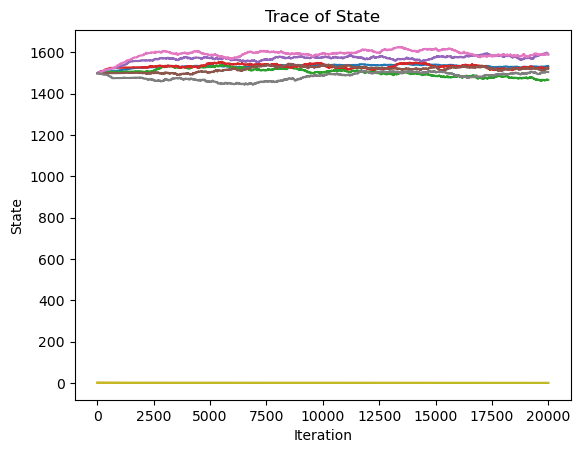

In [67]:
import numpy as np
import scipy.stats as stats

# Define the likelihood function
def likelihood(state, Y):
    log_likelihood = 0
    for i in range(Y.shape[0]):
        log_likelihood += stats.norm.logpdf(np.mean(Y[i]), loc=state[0], scale=np.sqrt(1/state[1]))
        for j in range(Y.shape[1]):
            log_likelihood += stats.norm.logpdf(Y[i, j], loc=state[i+2], scale=np.sqrt(1/state[8]))
    return log_likelihood

# Define the prior distributions
def log_prior_theta(state):
    mu = state[2:8]
    l = np.sum(mu)/6
    #s = 1/(6*state[1]+1)
    
    
    #l = (((10e-10)**2)*state[1]*np.sum(mu)) / (6*((10e-10)**2)*state[1]+1)
    s = ((10e-10)**2)/(6*((10e-10)**2)*state[1]+1)
    return stats.norm.logpdf(state[0], loc=l, scale=s)

def log_prior_tau_out(state):
    mu = state[2:8]
    a=0.001+3
    b=0.001+np.sum((mu-state[0])**2)/2
    return stats.gamma.logpdf(state[1], a=0.001, scale=1/b)

def log_prior_mu(state, i):
    mu = state[2:8]
    l = ((state[1]*state[0]) + state[8]*np.sum(Y[i])) / (state[1] + 5*state[8])
    s = 1/(state[1] + 5*state[8])
    return stats.norm.logpdf(mu[i], loc=l, scale=s)

def log_prior_tau_in(state):
    mu = state[2:8]
    a=0.001+15
    b=0.001
    for i in range(6):
        b+=np.sum((Y[i]-mu[i])**2)/2
    return stats.gamma.logpdf(state[8], a=a, scale=1/b)

def log_prior(state, i):
    if i==0:
        return log_prior_theta(state)
    elif i==1:
        return log_prior_tau_out(state)
    elif i<8:
        return log_prior_mu(state, i-2)
    else :
        return log_prior_tau_in(state)

# Define the proposal distribution
def propose_parameter(current_parameter, proposal_sd):
    proposal = current_parameter + np.random.normal(scale=proposal_sd)
    while proposal<0:
        proposal = current_parameter + np.random.normal(scale=proposal_sd)
    return proposal

# Metropolis-Hastings algorithm
def metropolis_hastings(initial_state, proposal_sd, iterations):
    state_chain = np.zeros((iterations+1, 9))
    state_chain[0]=initial_state
    acceptance_count = 0

    for i in range(iterations):
        proposed_variable = np.random.choice(a=9)
        
        proposed_state = np.copy(state_chain[i])
        proposed_state[proposed_variable] = propose_parameter(state_chain[i][proposed_variable], proposal_sd[proposed_variable])
        if proposed_state.any()<0:print("error")

        log_prior_ratio = log_prior(proposed_state, proposed_variable) - log_prior(state_chain[i], proposed_variable)

        log_likelihood_ratio = likelihood(proposed_state, Y) - likelihood(state_chain[i], Y)

        log_acceptance_ratio = log_prior_ratio + log_likelihood_ratio

            
        if np.log(np.random.uniform(0, 1)) < log_acceptance_ratio:
            state_chain[i+1] = proposed_state
            acceptance_count += 1        
            #if (proposed_variable==0): 
             #   print(log_acceptance_ratio, log_prior_ratio, log_likelihood_ratio)
              #  print(state_chain[i+1][0],state_chain[i][0])
               # print(log_prior(proposed_state, proposed_variable))
                #print(log_prior(state_chain[i], proposed_variable))
        else:
            state_chain[i+1] = state_chain[i]
            
        if i//500==i/500:
            print(acceptance_count)
    acceptance_rate = acceptance_count / iterations
    return state_chain, acceptance_rate

#DATA
Y = np.array([
    [1545, 1440, 1440, 1520, 1580],
    [1540, 1555, 1490, 1560, 1495],
    [1595, 1550, 1605, 1510, 1560],
    [1445, 1440, 1595, 1465, 1545],
    [1595, 1630, 1515, 1635, 1625],
    [1520, 1455, 1450, 1480, 1445]
])

# Parameters
initial_state = np.array([1500,1,1500,1500,1500,1500,1500,1500,1])
proposal_sd = np.array([1, 10e-3, 1, 1,1,1,1,1,10e-3])
iterations = 20000

# Run Metropolis-Hastings algorithm
state_chain, acceptance_rate = metropolis_hastings(initial_state, proposal_sd, iterations)

# Print acceptance rate
print("Acceptance rate:", acceptance_rate)

# Plot the trace of theta
import matplotlib.pyplot as plt
plt.plot(state_chain)
plt.xlabel('Iteration')
plt.ylabel('State')
plt.title('Trace of State')
plt.show()

In [75]:
print("on obtiens :\nTheta = ",state_chain[20000][0], "\nSigma2.between = ",1/state_chain[20000][1], "\nSigma2.within = ",1/state_chain[20000][8])

on obtiens :
Theta =  1534.2052253504787 
Sigma2.between =  2567.9468288159633 
Sigma2.within =  2703.8854912365946
